In [54]:
import torch
import numpy as np
import rasterio
from pathlib import Path


In [55]:
def load_model(model_path, device):
    import segmentation_models_pytorch as smp

    model = smp.DeepLabV3Plus(
        encoder_name="resnet50",
        encoder_weights=None,
        in_channels=3,
        classes=11
    )

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model


In [56]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = load_model("./models/landcover_model_deeplab_.pth", device)


In [57]:
import numpy as np
from pathlib import Path
from PIL import Image

def images_per_year_from_crops(
    root_dir,
    subfolder_index=4,
    exts=(".png", ".tif", ".tiff")
):
    """
    Lädt gecroppten Tiles pro Jahr, nur aus einem ausgewählten Foto-Unterordner.

    Args:
        root_dir (str/Path): abspeichert/ Hauptordner
        subfolder_index (int): Index des Foto-Unterordners pro Jahr
        exts (tuple): erlaubte Dateiendungen

    Returns:
        dict: {jahr: [np.array(Tiles)]}
    """
    root_dir = Path(root_dir)
    images_per_year = {}

    for year_dir in sorted(root_dir.iterdir()):
        if not year_dir.is_dir():
            continue

        # Unterordner auswählen (Foto-Ordner)
        subfolders = sorted([d for d in year_dir.iterdir() if d.is_dir()])
        if not subfolders:
            continue

        sf_idx = min(subfolder_index, len(subfolders) - 1)
        photo_dir = subfolders[sf_idx]

        # alle Tiles im Foto-Ordner laden
        tiles = []
        for tile_path in sorted(photo_dir.iterdir()):
            if tile_path.suffix.lower() not in exts:
                continue

            img = np.array(Image.open(tile_path))
            # für 2D Graustufen → (H,W,1)
            if img.ndim == 2:
                img = img[:, :, np.newaxis]
            tiles.append(img)

        if tiles:
            images_per_year[year_dir.name] = tiles

    return images_per_year





In [58]:
import torch
import numpy as np

def compute_tree_percentage_over_years(
    model,
    images_per_year,
    device,
    tree_label=1,
    threshold=0.5
):
    model.eval()
    years = sorted(images_per_year.keys())
    result = {}

    with torch.no_grad():
        for year in years:
            tree_pixels = 0
            total_pixels = 0

            for img in images_per_year[year]:
                # --- HWC → CHW + Batch ---
                if img.ndim == 2:
                    img = img[:, :, np.newaxis]
                x = torch.from_numpy(img).float().permute(2,0,1).unsqueeze(0).to(device)

                out = model(x)

                if out.shape[1] == 1:
                    mask = (torch.sigmoid(out) > threshold).long()
                else:
                    mask = torch.argmax(out, dim=1)

                mask = mask.squeeze().cpu().numpy()

                tree_pixels += np.sum(mask == tree_label)
                total_pixels += mask.size

            result[year] = 100 * tree_pixels / total_pixels

    return result


In [59]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_tree_percentage_over_years(
    model,
    images_per_year,
    device,
    tree_label=1,
    threshold=None
):
    model.eval()

    years = sorted(images_per_year.keys())
    tree_percentages = []

    with torch.no_grad():
        for year in years:
            imgs = images_per_year[year]

            tree_pixels = 0
            total_pixels = 0

            for img in imgs:
                # img: (C,H,W) → Tensor
                x = torch.tensor(img, dtype=torch.float32).unsqueeze(0).to(device)

                pred = model(x)

                if pred.shape[1] == 1:  # binary sigmoid
                    prob = torch.sigmoid(pred)
                    mask = (prob > (threshold or 0.5)).long()
                else:  # multiclass softmax
                    mask = torch.argmax(pred, dim=1)

                mask = mask.squeeze().cpu().numpy()

                tree_pixels += np.sum(mask == tree_label)
                total_pixels += mask.size

            tree_percentages.append(100 * tree_pixels / total_pixels)

    # ---- plot ----
    plt.figure(figsize=(6, 4))
    plt.plot(years, tree_percentages, marker="o")
    plt.ylabel("Tree area [%]")
    plt.xlabel("Year")
    plt.title("Tree coverage over years")
    plt.grid(True)
    plt.show()

    return dict(zip(years, tree_percentages))


In [60]:

import numpy as np
import rasterio
from PIL import Image
from pathlib import Path

def crop_images_recursive_keep_channels(
    input_root,
    output_root="./abspeichert",
    tile_size=256,
    exts=(".tif", ".tiff", ".png", ".jpg", ".jpeg")
):
    """
    Cropt Bilder rekursiv in 256x256 Tiles, speichert alle Kanäle.
    Pro Originalbild wird ein Unterordner im output_root erstellt.
    """
    input_root = Path(input_root)
    output_root = Path(output_root)
    output_root.mkdir(parents=True, exist_ok=True)

    for img_path in input_root.rglob("*"):
        if img_path.suffix.lower() not in exts:
            continue

        rel = img_path.relative_to(input_root)
        out_dir = output_root / rel.with_suffix("")
        out_dir.mkdir(parents=True, exist_ok=True)

        # ---- Bild laden ----
        if img_path.suffix.lower() in (".tif", ".tiff"):
            with rasterio.open(img_path) as src:
                img = src.read()  # (C,H,W)
                img = np.transpose(img, (1, 2, 0))  # -> (H,W,C)
        else:
            img = np.array(Image.open(img_path))

        # ---- float → uint8 ----
        if img.dtype != np.uint8:
            img = img.astype(np.float32)
            img -= img.min()
            img /= (img.max() + 1e-8)
            img = (img * 255).astype(np.uint8)

        H, W = img.shape[:2]
        C = img.shape[2] if img.ndim == 3 else 1

        tile_id = 0
        for y in range(0, H - tile_size + 1, tile_size):
            for x in range(0, W - tile_size + 1, tile_size):
                tile = img[y:y+tile_size, x:x+tile_size]

                tile_path = out_dir / f"tile_{tile_id:04d}.png"

                # ---- PIL erwartet 2D oder 3D mit C=3/4 ----
                if C == 1:
                    Image.fromarray(tile.squeeze(), mode="L").save(tile_path)
                elif C == 3:
                    Image.fromarray(tile, mode="RGB").save(tile_path)
                elif C == 4:
                    Image.fromarray(tile, mode="RGBA").save(tile_path)
                else:
                    # mehr als 4 Kanäle → speichere als .npy
                    np.save(tile_path.with_suffix(".npy"), tile)

                tile_id += 1

        print(f"✔ {img_path} → {tile_id} tiles")


In [61]:
crop_images_recursive_keep_channels(
    input_root="./deforest/",
    output_root="./abspeichert",
    tile_size=256
)


✔ deforest/2022/2022-07-13-00-00_2022-07-13-23-59_Sentinel-2_L2A_True_color.tiff → 15 tiles
✔ deforest/2022/2022-07-13-00-00_2022-07-13-23-59_Sentinel-2_L2A_B02_(Raw).tiff → 15 tiles
✔ deforest/2022/2022-07-13-00-00_2022-07-13-23-59_Sentinel-2_L2A_B08_(Raw).tiff → 15 tiles
✔ deforest/2022/2022-07-13-00-00_2022-07-13-23-59_Sentinel-2_L2A_B03_(Raw).tiff → 15 tiles
✔ deforest/2022/2022-07-13-00-00_2022-07-13-23-59_Sentinel-2_L2A_B04_(Raw).tiff → 15 tiles
✔ deforest/2018/2018-07-21-00-00_2018-07-21-23-59_Sentinel-2_L2A_B08_(Raw).tiff → 15 tiles
✔ deforest/2018/2018-07-21-00-00_2018-07-21-23-59_Sentinel-2_L2A_True_color.tiff → 15 tiles
✔ deforest/2018/2018-07-21-00-00_2018-07-21-23-59_Sentinel-2_L2A_B04_(Raw).tiff → 15 tiles
✔ deforest/2018/2018-07-21-00-00_2018-07-21-23-59_Sentinel-2_L2A_B02_(Raw).tiff → 15 tiles
✔ deforest/2018/2018-07-21-00-00_2018-07-21-23-59_Sentinel-2_L2A_B03_(Raw).tiff → 15 tiles
✔ deforest/2020/2020-07-15-00-00_2020-07-15-23-59_Sentinel-2_L2A_True_color.tiff → 15 ti

In [62]:
images_per_year = images_per_year_from_crops(
    "./abspeichert/"
)


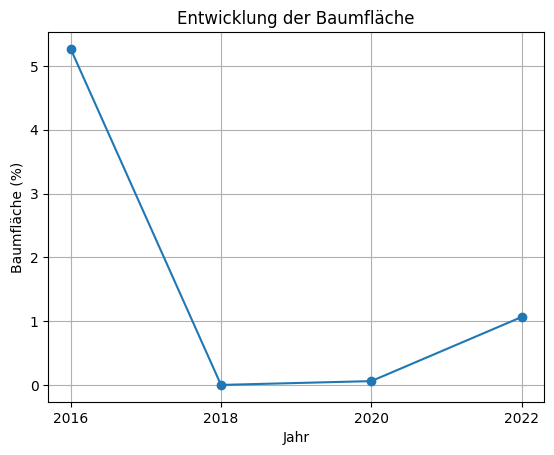

In [63]:
import matplotlib.pyplot as plt

tree_percent = compute_tree_percentage_over_years(model, images_per_year, device)

plt.plot(list(tree_percent.keys()), list(tree_percent.values()), marker="o")
plt.xlabel("Jahr")
plt.ylabel("Baumfläche (%)")
plt.title("Entwicklung der Baumfläche")
plt.grid(True)
plt.show()


In [64]:
def evaluate_metrics(model, images, masks, device):
    dices, ious, precs, recs = [], [], [], []

    def dice(p, g):
        tp = np.sum((p == 1) & (g == 1))
        fp = np.sum((p == 1) & (g == 0))
        fn = np.sum((p == 0) & (g == 1))
        return (2*tp) / (2*tp + fp + fn + 1e-8)

    def iou(p, g):
        tp = np.sum((p == 1) & (g == 1))
        fp = np.sum((p == 1) & (g == 0))
        fn = np.sum((p == 0) & (g == 1))
        return tp / (tp + fp + fn + 1e-8)

    def precision(p, g):
        tp = np.sum((p == 1) & (g == 1))
        fp = np.sum((p == 1) & (g == 0))
        return tp / (tp + fp + 1e-8)

    def recall(p, g):
        tp = np.sum((p == 1) & (g == 1))
        fn = np.sum((p == 0) & (g == 1))
        return tp / (tp + fn + 1e-8)

    with torch.no_grad():
        for img, gt in zip(images, masks):
            x = torch.from_numpy(img).float().unsqueeze(0).to(device)
            pred = torch.argmax(model(x), dim=1)[0].cpu().numpy()

            dices.append(dice(pred, gt))
            ious.append(iou(pred, gt))
            precs.append(precision(pred, gt))
            recs.append(recall(pred, gt))

    return {
        "dice": np.mean(dices),
        "iou": np.mean(ious),
        "precision": np.mean(precs),
        "recall": np.mean(recs)
    }


In [74]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from matplotlib.colors import ListedColormap

def show_tile_across_years(
    model,
    images_per_year,
    device="cpu",
    tile_index=0,
    tree_label=1,
    threshold=0.5
):
    """
    Zeigt ein bestimmtes Tile (per index) über alle Jahre nebeneinander: 
    Original-Tile | Prediction

    Args:
        model: dein PyTorch Modell
        images_per_year: dict {jahr: [Tiles]}
        device: "cuda" oder "cpu"
        tile_index: Index des Tiles pro Jahr
        tree_label: Label für Bäume
        threshold: Schwelle bei binary output
    """
    worldcover_colors = [
        (1.0, 1.0, 1.0),  # Background
        (0.0, 0.6, 0.0),  # 10 Tree cover
        (0.7, 1.0, 0.4),  # 30 Grassland
        (1.0, 1.0, 0.5),  # 40 Cropland
        (0.8, 0.2, 0.2),  # 50 Built-up
        (0.9, 0.9, 0.9),  # 60 Bare / sparse
        (1.0, 1.0, 1.0),  # 70 Snow and ice
        (0.0, 0.3, 0.9),  # 80 Water
        (0.4, 0.8, 0.8),  # 90 Herbaceous wetland
        (0.0, 0.5, 0.0),  # 95 Mangroves
        (0.6, 0.6, 0.6),  # 100 Moss & lichen
    ]
    # Wir arbeiten intern mit Klassen 0-10, also cmap auf 0-10
    cmap = ListedColormap(worldcover_colors)
    model.eval()
    years = sorted(images_per_year.keys())
    n_years = len(years)

    fig, axes = plt.subplots(n_years, 2, figsize=(8, 4*n_years))

    if n_years == 1:
        axes = [axes]  # iterable machen

    with torch.no_grad():
        for i, year in enumerate(years):
            tiles = images_per_year[year]
            if tile_index >= len(tiles):
                print(f"⚠️ Jahr {year} hat kein Tile mit Index {tile_index}, übersprungen")
                continue

            tile = tiles[tile_index]

            # --- Prediction ---
            x = torch.from_numpy(tile).float().permute(2,0,1).unsqueeze(0).to(device)
            x = x / 255.0  # falls trainiert auf 0–1

            out = model(x)

            if out.shape[1] == 1:
                mask = (torch.sigmoid(out) > threshold).long()
            else:
                mask = torch.argmax(out, dim=1)

            mask = mask.squeeze().cpu().numpy()
            print(mask)
            # --- Original anzeigen ---
            ax_orig = axes[i][0]
            if tile.shape[2] == 1:
                ax_orig.imshow(tile[:,:,0], cmap="gray")
            else:
                ax_orig.imshow(tile)
            ax_orig.set_title(f"{year} Original")
            ax_orig.axis("off")

            # --- Prediction anzeigen ---
            ax_pred = axes[i][1]
            ax_pred.imshow(mask, cmap=cmap)
            ax_pred.set_title(f"{year} Prediction")
            ax_pred.axis("off")

    plt.tight_layout()
    plt.show()



[[3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 ...
 [4 4 4 ... 3 3 3]
 [4 4 4 ... 3 3 3]
 [4 4 4 ... 3 3 3]]
[[3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 ...
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]]
[[1 1 3 ... 3 3 3]
 [1 1 1 ... 3 3 3]
 [1 1 1 ... 3 3 3]
 ...
 [3 1 1 ... 3 3 3]
 [1 1 1 ... 3 3 3]
 [1 1 1 ... 3 3 3]]
[[3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 4]
 ...
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]]


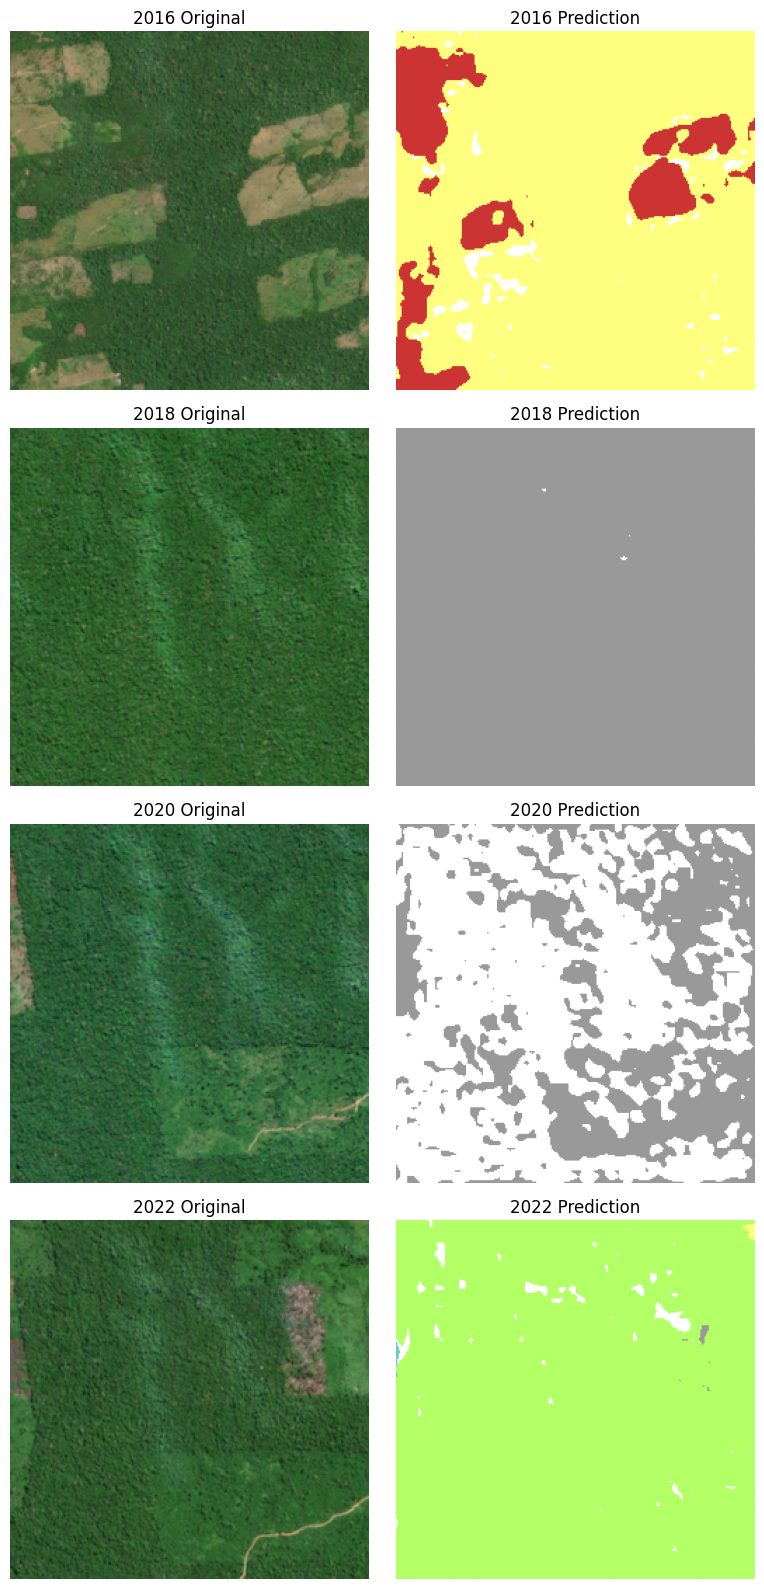

In [76]:
show_tile_across_years(
    model=model,
    images_per_year=images_per_year,
    
    device=device,
    tile_index=5
)


In [67]:
metrics = evaluate_metrics(model, test_images, test_masks, device)
metrics


NameError: name 'test_images' is not defined